In [267]:
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from itertools import product
from functools import reduce 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

factors_dir = os.path.join('data', 'factors')
random_state = 40


def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res


def mse(fact, predict):
    return ((fact - (predict))**2).sum()/fact.shape[0]

In [2]:
# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()

In [3]:
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

In [4]:
# Получаем имена всех столбиков, в которых данные являются погодичными
annual_data = []
for column_name in all_df.columns:
    if all_df[column_name].dropna().shape[0] < 40:
        annual_data.append(column_name)

In [5]:
# Тренировочную выборку(исключая из нее погодичные данные) и целевую
x_df = all_df['1996-02':'2019'].drop(annual_data+['RTSI'], axis=1).resample('1m').last().dropna()
y_df = all_df['RTSI']['1996':'2019'].resample('1m').last().shift(1).dropna()

x_df = x_df.shift(1).dropna()
y_df = y_df[1:]

In [6]:
tmp = x_df[['SP500', 'SSE', 'DAX', 'FTSE']]
tmp_centered = [tmp[col]-tmp[col].mean() for col in tmp.columns]
tmp_cov = np.cov(tmp_centered)
_, tmp_eig = np.linalg.eig(tmp_cov)
tmp_v = tmp_eig[:, 0]

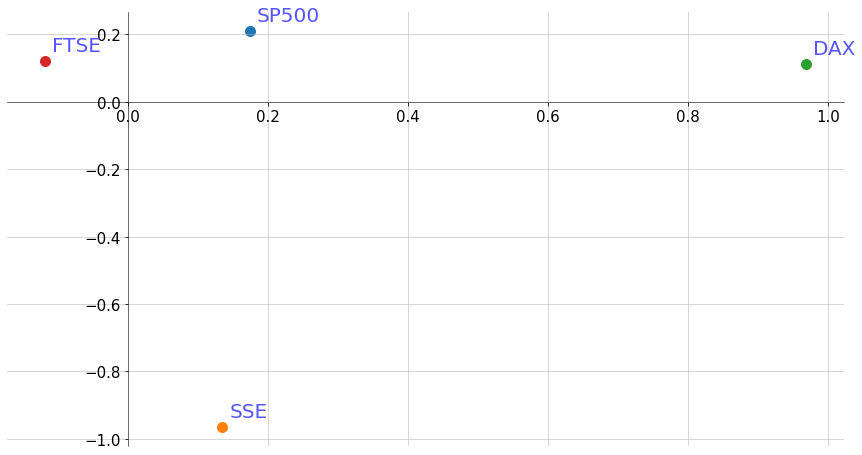

In [7]:
for x, y, name in zip(*tmp_eig[:2], tmp.columns):
    plt.scatter(x, y, s=100);
    plt.text(x+.01, y+.03, name, fontsize=20, color='#55ff')
    
ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_linewidth(.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [8]:
pca = PCA(n_components=2)
xpca_reduced = pca.fit_transform(tmp)
print('Процент объясненной дисперсии', pca.explained_variance_ratio_)

dax_sp500 = pd.Series(xpca_reduced[:, 0], index=tmp.index)
sse_sp500 = pd.Series(xpca_reduced[:, 1], index=tmp.index)

Процент объясненной дисперсии [0.93919021 0.04369556]


In [9]:
x_df['DAX-SP500'] = dax_sp500
x_df['SSE-SP500'] = sse_sp500
x_df['TIME'] = np.arange(1, x_df.shape[0]+1)

In [10]:
# Размер тестовой выборки
# test_size = .01
# Xtrn, Xtest, Ytrn, Ytest = train_test_split(
#     x_df.drop(['FTSE', 'DAX', 'SP500', 'SSE'], axis=1)[:'2019-06'],
#     y_df[:'2019-06'], test_size=test_size, random_state=random_state)

Xtrn = x_df[:'2017'].drop(['FTSE', 'DAX', 'SP500', 'SSE'], axis=1)
Xtest = x_df['2018':].drop(['FTSE', 'DAX', 'SP500', 'SSE'], axis=1)

Ytrn = y_df[:'2017']
Ytest = y_df['2018':]

## RandomForest

### Принцип работы
Множество решающих деревьев, для каждого дерева берется случайная выборка размером *max_samples*, для каждого разветвления в дереве просматривается *max_features* случайных признаков. Выбирается лучший признак и расщепление по нему, так делаем пока в листьях не останется представитель одного класса/пока не достигнута максимальная глубина дерева

### Аргументы
* ***n_estimators*** - по умолчанию = 100. Количество деревьев в "лесу". Увеличение числа деревьев улучшает качество модели, но приходится уделять больше времени её настройке. Качество модели на тестовой выборке выходит на асимптоту, поэтому после определенного количества деревьев, не имеет смысл увеличивать дальше.


* ***criterion*** - по умолчанию = 'mse'. Критерий разветвления. На выбор есть 2 критерия: mse и mae.


* ***max_depth*** - по умолчанию = None, т.е неограничена. Максимальная глубина дерева, чем больше это число, тем выше качество модели на обучающей выборке, тем дольше строится дерево, и, возможно, ведет к переобучению. Верно и обратное утверждение, чем меньше значение, тем быстрее строится дерево, ниже качество модели на обучающей выборке, и ведет к недообучению. Рекомендуется использовать максимальную глубину, за исключением случаев когда объектов очень много. Неглубокие деревья следует строит когда в выборке много выбросов.


* ***min_samples_split*** - по умолчанию = 2. Минимальное количество объектов, при которых выполняется разветвление. Увеличение этого параметра ведет к уменьшению времени построения дерева, и к возможному недообучению. Оптимального значения нет.


* ***min_samples_leaf*** - по умолчанию = 1. Минимальное число объектов в листьях. Увеличение этого параметра уменьшает время построения дерева и может привести к недообучению. Для задач регрессии минимальное количество объектов в листе рекомендуется устанавливать = 5.


* ***min_weight_fraction_leaf*** - по умолчанию = 0.0. Минимальная взвешенная часть суммы всех весов (всех входных выборок) необходимая для конечного узла. Выборки имеют одинаковый вес, если *sample_weight* (метод .fit) не передается.


* ***max_features*** - по умолчанию = 'auto', т.е все признаки. Количество признаков для выбора разветвления. Считается одним из самых важных параметров. Для выбора разветвления берется *max_features* количество случайных признаков и из них выбирается самый лучший. При увеличении этого параметра увеличивается время построения леса, а также деревья становятся однообразнее, за счет того, что с большей вероятностью, буду иметь набор признаков для выбора лучшего из них. Для задач классификации обычно берут sqrt(n_features), где n_features - общее количество признаков, для задач регрессии - n_features/3. Если передать целое число, то будет взято n_features признаков, если вещественное, то int(max_features * n_features) признаков, 'auto' - все признаки, 'sqrt' - sqrt(n_features), 'log2' - log2(n_features), None - все признаки


* ***max_leaf_nodes*** - по умолчанию = None(неограничено). Максимальное количество листьев в дереве. Увеличение этого числа способствует увеличению времени построения модели, а уменьшение может привести к недообучению.


* ***min_impurity_decrease*** - по умолчанию = 0.0. Минимальная разница между значением, определенным по *criterion* текущего узла, и суммы двух последующих. Если разница больше, то узел считается концевым (т.е листом).


* ***min_impurity_split*** - по умолчанию None(1e-7). Минимальное значение текущего узла, определенное по *criterion*. Если значение меньше, то узел становится листом. Этот аргумент является устаревшим, рекомендуется использовать *min_impurity_decrease*.


* ***bootstrap*** - по умолчанию = True. Если False, то для построения каждого дерева используется полный датасет.


* ***oob_score*** - по умолчанию = False. Следует ли использовать готовые выборки для оценки R<sup>2</sup> на неизвестных данных.


* ***n_jobs*** - по умолчанию = None(1). Количество процессоров задействованных в "строительстве" дерева. При указании -1 будут задействованы все процессоры.


* ***random_state*** - по умолчанию = None. Передача числа позволяет в дальнейшем воспроизводить тест.


* ***verbose*** - по умолчанию = 0. "Многословность" исходящей после обучения информации.


* ***warm_start*** - по умолчанию = False. Если задано значение True, повторно используется решение предыдущего вызова, для обучения и добавления дополнительных оценок в ансамбль, в противном случае просто обучется полностью новый лес.


* ***ccp_alpha*** - по умолчанию = 0.0. Параметр сложности, используемый для сокращения минимальной стоимости и сложности. Будет выбрано поддерево с наибольшей сложностью затрат, которое меньше, чем *ccp_alpha*. По умолчанию обрезка не выполняется.


* ***max_samples*** - по умолчанию = None. Количество записей для обучения дерева(актуально только когда *bootstrap* = True). Если None, то обучается на всей выборке, если целое число, то на *max_samples* записях, если вещественное, то на max_samples * N записях, где N - количество записей.

### Найдем оптимальное количество деревьев для случайного леса

100%|██████████| 30/30 [00:05<00:00,  5.98it/s]


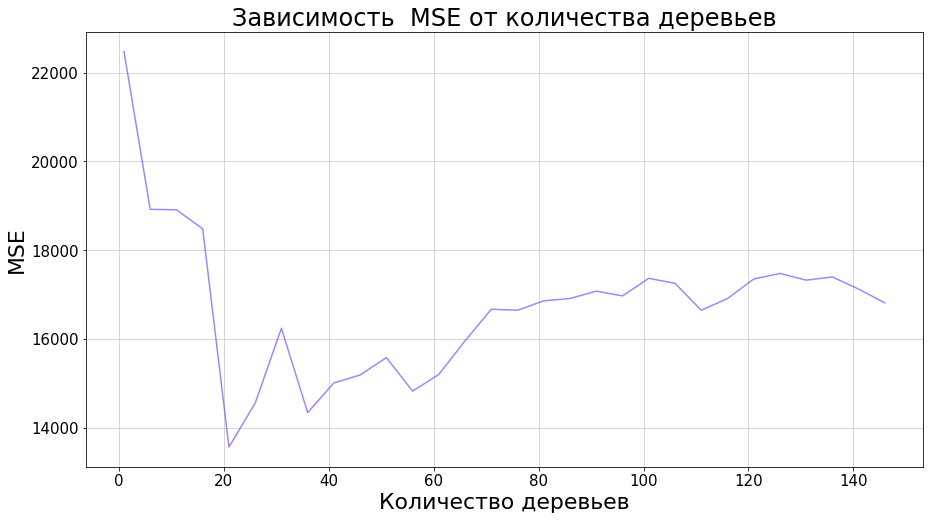

In [11]:
tmp_result = np.array([])
tmp_grid_n_estimators = np.arange(1, 151, 5)
for i in tqdm(tmp_grid_n_estimators):
    tmp_rforest_fitted_model = RandomForestRegressor(
        n_estimators=i, random_state=random_state, max_depth=5
    ).fit(Xtrn, Ytrn)
    tmp_rforest_r2 = r2_score(Ytest, tmp_rforest_fitted_model.predict(Xtest))
    tmp_rforest_mse = mse(Ytest, tmp_rforest_fitted_model.predict(Xtest))
    tmp_result = np.append(tmp_result, tmp_rforest_mse)

# Отрисовка результата
plt.plot(tmp_grid_n_estimators, tmp_result, color='#63f9')

# Отрисовка коридора, верх которого = среднему значению + 0.01, а низ - среднему значению - 0.01
# corridor_range = (50, max(tmp_grid_n_estimators))
# corridor_top = tmp_result[corridor_range[0]:].mean()+.01
# corridor_bottom = tmp_result[corridor_range[0]:].mean()-.01
# plt.fill_between(
#     corridor_range,
#     corridor_top,
#     corridor_bottom,
#     color='#6f84',
# )
# plt.hlines(
#     [corridor_top, corridor_bottom],
#     *corridor_range,
#     color='#200b'
# )
# plt.title(f'Зависимость R{chr(178)} от количества деревьев')
plt.title(f'Зависимость  MSE от количества деревьев')
plt.xlabel('Количество деревьев')
# plt.ylabel(f'R{chr(178)}')
plt.ylabel('MSE')
# plt.text(
#     corridor_range[0]+4,
#     corridor_bottom-.01,
#     'По коридору видно, что качество модели не меняется после 50 деревьев',
#     fontsize=15
# )
plt.show()

### Вывод:
#### Качество модели, после количества деревьев > 50, остается примерно одинаковым , не отклоняясь от среднего значения больше чем на 0.01, поэтому оставим значение по умолчанию (100)

### С помощью GridSearchCV переберем гиперпараметры
Критерия всего 2, поэтому подставим оба. Максимальную глубину дерева изменять не будем, так как выборка не является большой, и уменьшение этого гиперпараметра может привести к недообучению. По этой же причине не будем изменять *max_leaf_nodes*, *min_impurity_decrease*, *min_impurity_split*. У нас задача регрессии, поэтому попробуем немного перебрать *min_samples_leaf*. Также для задач регрессии рекомендуется *max_features* указывать как треть от всех признаков.

In [12]:
rforest_grid_params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(1, 4),
    'max_features': ('sqrt',),
    'n_estimators': np.arange(18, 26, 1),
    'max_samples': np.arange(.1, 1, .1)
}
count = reduce(lambda x, y: x*y, map(len, rforest_grid_params.values()))

forests = []
for args in tqdm(product(*rforest_grid_params.values()), total=count, desc=' tree'):
    params = dict(zip(rforest_grid_params.keys(), args))
    rforest_model = RandomForestRegressor(n_jobs=-1, random_state=random_state, **params)
    rforest_fitted_model = rforest_model.fit(Xtrn, Ytrn)
    rforest_predicted = rforest_fitted_model.predict(Xtest)
    rforest_r2 = r2_score(Ytest, rforest_predicted)
    rforest_mse = mse(Ytest, rforest_predicted)
    forests.append((rforest_fitted_model, rforest_predicted, rforest_r2, rforest_mse))

# plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
# plt.scatter(
#     Ytest.index, rforest_predicted, 
#     color='red', label='Предсказанные значения', s=25
# )
# plt.title(f'Случайный лес (R{chr(178)}: {rforest_r2:.4f})')
# plt.legend()
# plt.show()

 tree: 100%|██████████| 1080/1080 [04:32<00:00,  3.97it/s]


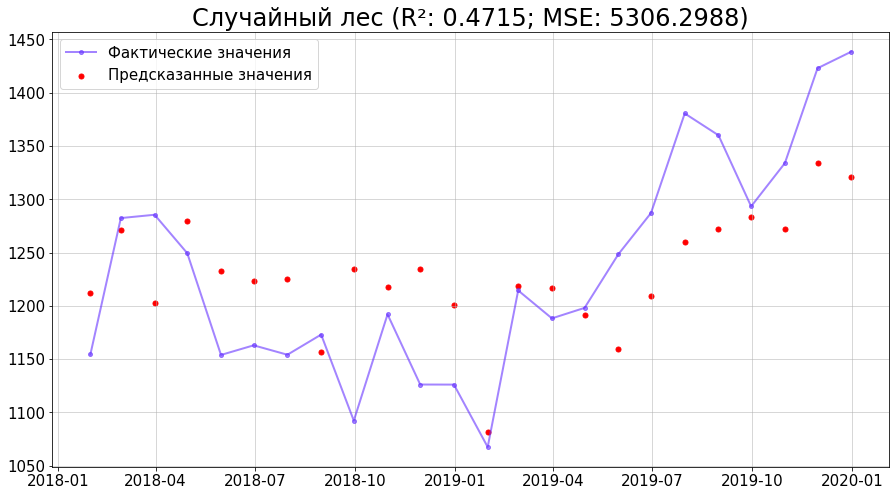

In [13]:
min_forest = min(forests, key=lambda x: x[-1])

plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
plt.scatter(
    Ytest.index, min_forest[1], 
    color='red', label='Предсказанные значения', s=25
)
plt.title(f'Случайный лес (R{chr(178)}: {min_forest[2]:.4f}; MSE: {min_forest[-1]:.4f})')
plt.legend()
plt.show()

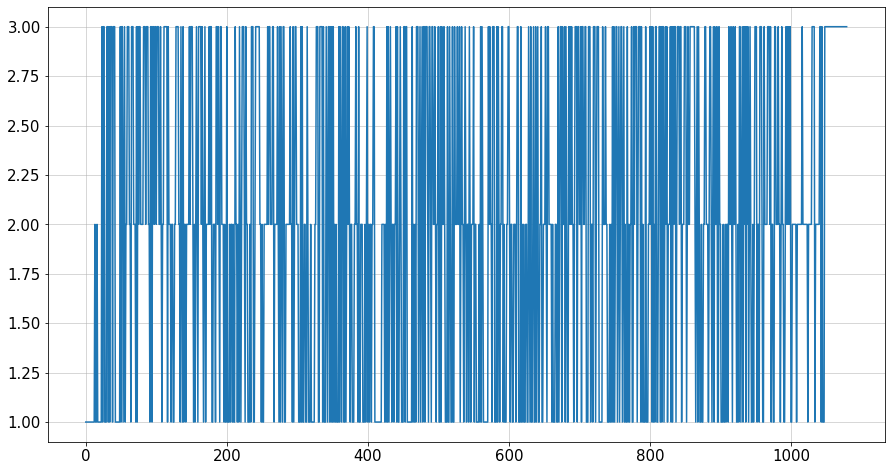

In [14]:
plt.plot(list(map(lambda x: x[0].min_samples_leaf, sorted(forests, key=lambda x: x[-1]))))

In [15]:
for i in sorted(forests, key=lambda x: x[-1])[:10]:
    print(i)
    print('='*100)
    print('='*100)

(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=18, n_jobs=-1, oob_score=False,
                      random_state=40, verbose=0, warm_start=False), array([1212.19015212, 1270.71320767, 1203.12792989, 1279.79968915,
       1232.87207804, 1223.1026336 , 1224.77930026, 1156.30206481,
       1234.21249471, 1217.60545767, 1234.21249471, 1200.61394841,
       1081.60550926, 1218.83689815, 1217.16023148, 1191.53731481,
       1159.15701852, 1209.1115291 , 1260.37735582, 1271.67237434,
       1283.19422619, 1271.79920767, 1334.15209656, 1320.80862434]), 0.4715326174357697, 5306.298832777923)
(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='ms

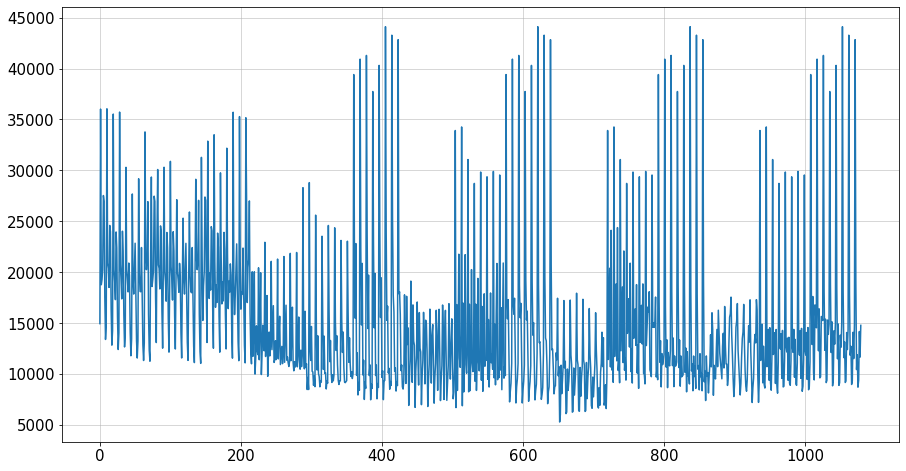

In [16]:
plt.plot(list(map(lambda x: x[-1], forests)))

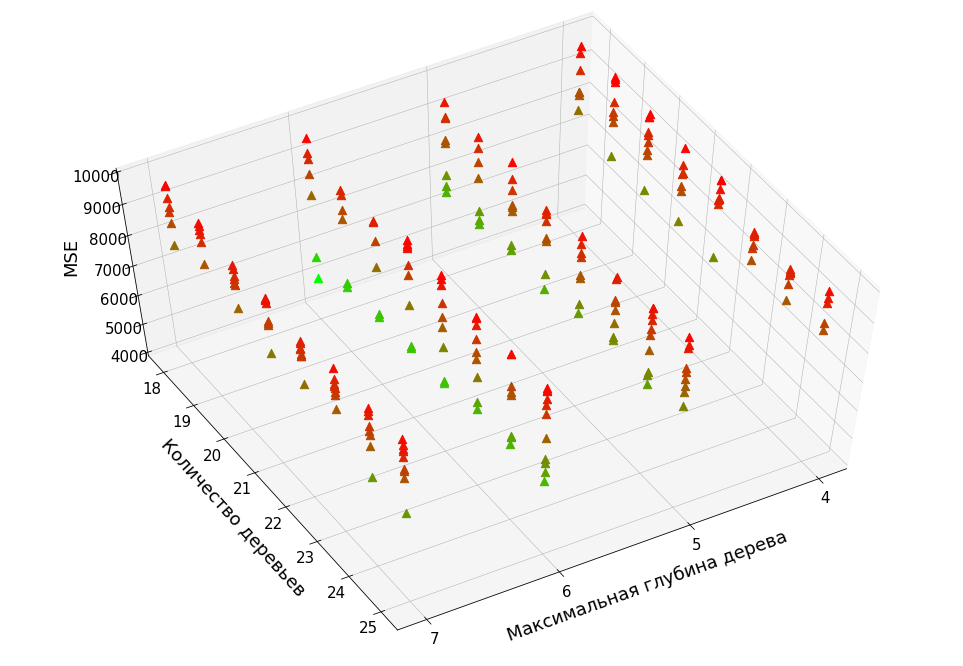

In [314]:
fig = plt.figure(figsize=(17, 12))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection='3d')
ax.set_xlabel('Максимальная глубина дерева', labelpad=15, fontsize=18)
ax.set_ylabel('Количество деревьев', labelpad=15, fontsize=18)
ax.set_zlabel('MSE', labelpad=15, rotation=90, fontsize=18)

data = sorted(filter(lambda x: x[-1] < 10000, forests), key=lambda x: x[-1])
# Grab some test data.
X = np.array(list(map(lambda x: x[0].max_depth, data)))
Y = np.array(list(map(lambda x: x[0].n_estimators, data)))
# X, Y = np.meshgrid(X, Y)
Z = np.array(list(map(lambda x: x[-1], data)))

# Plot a basic wireframe.
for x, y, z in zip(X, Y, Z):
    r = (z-Z.min()) / (Z.max() - Z.min())
    g = 1 - r
    color = np.array([r, g, 0, 1]).reshape(1, -1)
    surf = ax.scatter(x, y, z, marker='^', c=color, s=70)
ax.view_init(60, 60)

# Customize the z axis.
ax.set_zlim(4000, 10000)
plt.xticks(np.arange(3, 8))
# Add a color bar which maps values to colors.


# fig, ax = plt.subplots(figsize=(1, 15))
# fig.subplots_adjust(bottom=0.5)

# cmap = mplt.cm.RdYlGn_r
# norm = mplt.colors.Normalize(vmin=4000, vmax=10_000)

# cb1 = mplt.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
# cb1.set_label('MSE')
# fig.show()

plt.show()

In [17]:
# Для сохранения дерева в dot файл
# tree = RandomForestRegressor(n_estimators=100, max_features ='sqrt')
# tree.fit(Xtest, Ytest)
# export_graphviz(tree.estimators_[5], out_file='tree.dot', 
#                 feature_names = Xtest.columns,
#                 class_names = 'RTSI',
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)
# Преобразование dot в png
# dot -Tpng tree.dot -o tree.png -Gdpi=600


#  # Limit depth of tree to 3 levels
# rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
# rf_small.fit(train_features, train_labels)
# # Extract the small tree
# tree_small = rf_small.estimators_[5]
# # Save the tree as a png image
# export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# (graph, ) = pydot.graph_from_dot_file('small_tree.dot')
# graph.write_png('small_tree.png');

### SVR

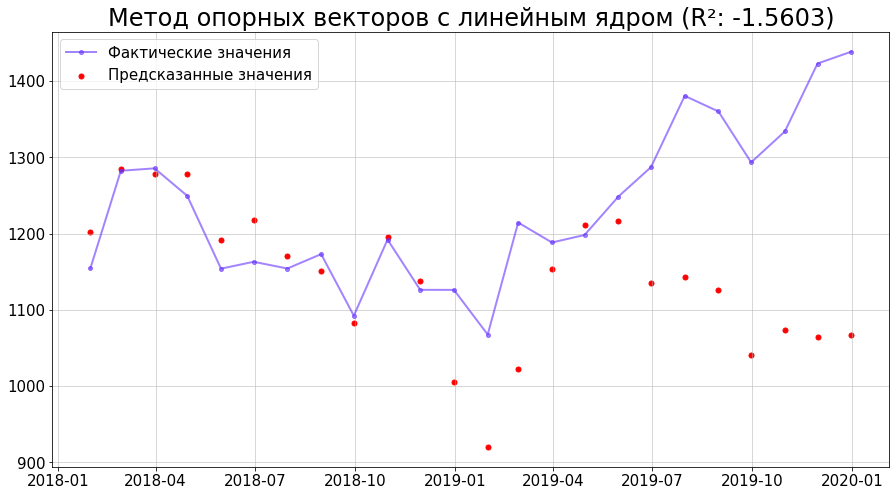

In [18]:
svr_model = SVR(kernel='linear')
best_svr_model = svr_model.fit(Xtrn, Ytrn)
svr_r2 = r2_score(Ytest, best_svr_model.predict(Xtest))

plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
plt.scatter(Ytest.index, best_svr_model.predict(Xtest), color='red', label='Предсказанные значения', s=25)
plt.title(f'Метод опорных векторов с линейным ядром (R{chr(178)}: {svr_r2:.4f})')
plt.legend()
plt.show()

### LGBM

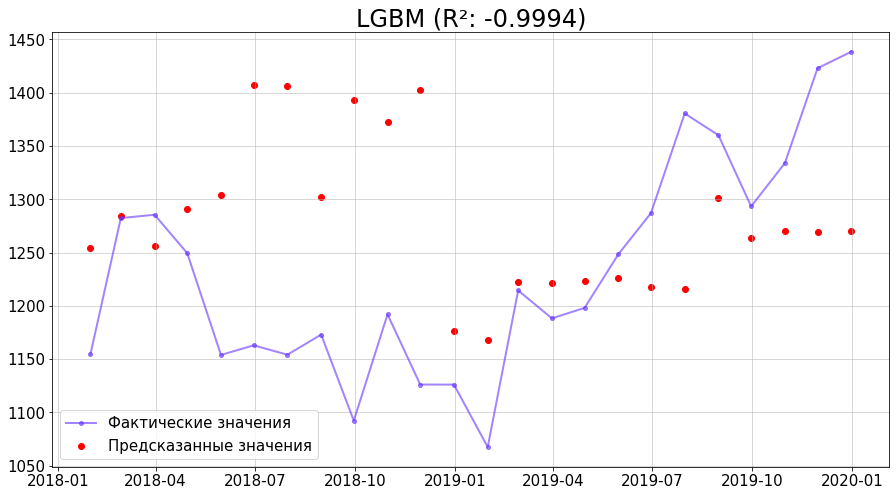

In [19]:
lgbm_model = LGBMRegressor()
best_lgbm_model = lgbm_model.fit(Xtrn, Ytrn)
lgbm_r2 = r2_score(Ytest, best_lgbm_model.predict(Xtest))

plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
plt.scatter(Ytest.index, best_lgbm_model.predict(Xtest), color='red', label='Предсказанные значения')
plt.title(f'LGBM (R{chr(178)}: {lgbm_r2:.4f})')
plt.legend()
plt.show()

### XGBoost

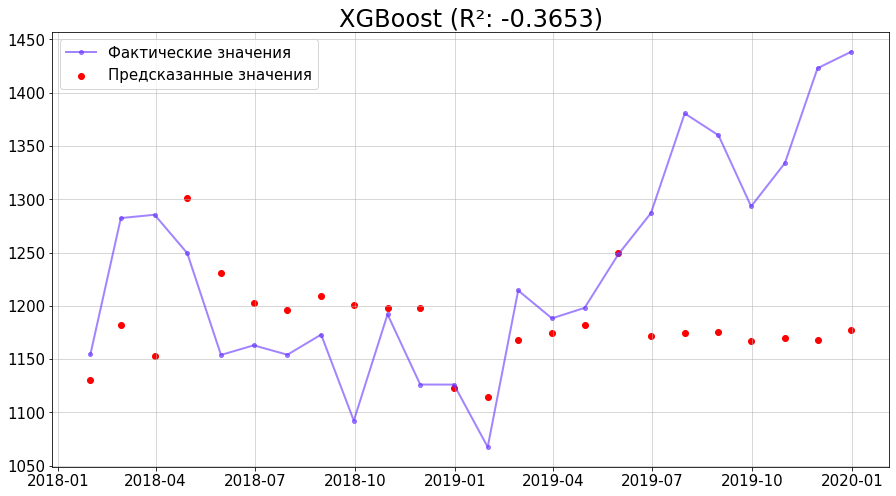

In [20]:
xgb_model = XGBRegressor()
best_xgb_model = xgb_model.fit(Xtrn, Ytrn)
xgb_r2 = r2_score(Ytest, best_xgb_model.predict(Xtest))

plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
plt.scatter(Ytest.index, best_xgb_model.predict(Xtest), color='red', label='Предсказанные значения')
plt.title(f'XGBoost (R{chr(178)}: {xgb_r2:.4f})')
plt.legend()
plt.show()